# PAL2 Demo

In [1]:
from __future__ import division
import numpy as np
import PAL2
from PAL2 import PALmodels
from PAL2 import PALutils
from PAL2 import PALdatafile
from PAL2 import PALInferencePTMCMC as ptmcmc
from PAL2 import bayesutils as bu
import glob
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler

## Read in MDC data files into HDF5 file

In [2]:
datadir = PAL2.__path__[0] + '/data/NANOGrav_dfg+12_20120911/'
parFiles = glob.glob(datadir + '/*.par')
timFiles = glob.glob(datadir + '/*.tim')

# sort 
parFiles.sort()
timFiles.sort()

In [3]:
# make hdf5 file
h5filename = './h5file.hdf5'
df = PALdatafile.DataFile(h5filename)

# add pulsars to file
for p, t in zip(parFiles, timFiles):
    df.addTempoPulsar(p, t, iterations=0)

## Setup up Likelihood Model

In [4]:
# lets just use one pulsar for now
pulsars = ['1643-1224']
model = PALmodels.PTAmodels(h5filename, pulsars=pulsars)

# initialize a model that will include a search for 
# powerlaw red noise + efac (efac is set by default)
# + equad + ecorr
fullmodel = model.makeModelDict(incRedNoise=True, noiseModel='powerlaw', 
                                nfreqs=50, incJitterEquad=True, incEquad=True,
                                likfunc='mark6')

# initialize model
model.initModel(fullmodel, memsave=True, fromFile=False, verbose=False)

In [5]:
# get names of varying parameters
pars = model.get_varying_parameters()
print(pars)

['efac_1643-1224-Rcvr1_2-GASP', 'efac_1643-1224-Rcvr_800-GASP', 'jitter_q_1643-1224-Rcvr1_2-GASP', 'jitter_q_1643-1224-Rcvr_800-GASP', 'equad_1643-1224-Rcvr1_2-GASP', 'equad_1643-1224-Rcvr_800-GASP', 'RN-Amplitude_1643-1224', 'RN-spectral-index_1643-1224']


## Setup MCMC run for single pulsar noise analysis

In [6]:
# set initial parameters. This will randomly draw parameters from the prior.
p0 = model.initParameters()

# Set initial covariance jump sizes. 
# This uses the pwidth key in the parameter dictionaries
cov = model.initJumpCovariance()

In [7]:
# define likelihood and prior function
lnlike = model.mark6LogLikelihood
lnprior = model.mark3LogPrior

In [8]:
# time likelihood
%lprun -f lnlike lnlike(p0, incJitter=True)

### Can define jump groups here

In [9]:
# parameter groups allow you to only jump in certain groups of parameters at a time

# for example you can do the following if you want to separate out Red noise jumps
ind = []

# pull out powerlaw parameters from overall parameter array
ids = model.get_parameter_indices('powerlaw', corr='single', split=True)

# add to list
[ind.append(id) for id in ids]

# make list of lists that has all parameters and then individual indices defined above
ind.insert(0, range(len(p0)))

# can give this list to the sampler by including the keyword argument groups=ind

In [10]:
# setup sampler

# make keyword dictionary for jitter parameter
loglkwargs = {}
loglkwargs['incJitter'] = True

sampler = ptmcmc.PTSampler(len(p0), lnlike, lnprior, cov,  outDir='./chains/',
                           loglkwargs=loglkwargs)

### Add additional jump proposals here if desired

In [11]:
# can add additional custom jump proposals with a given weight [2=small, 5=medium, 10=Large, 20=very large]
# the weights give some indication as to how often a given proposal is used in the cycle

#sampler.addProposalToCycle(name_of_function, weight)

In [12]:
# sampler for a max of 100 000 samples or for 1000 effective samples
N = 100000
Neff = 1000
sampler.sample(p0, N, neff=Neff)

Finished 10.00 percent in 47.539332 s Acceptance rate = 0.3008Adding DE jump with weight 20
Finished 99.00 percent in 406.220108 s Acceptance rate = 0.214929
Run Complete


## Post-processing

In [2]:
# read in chain file and set burn in to be 25% of chain length
chain = np.loadtxt('chains/chain_1.txt')
burn = 0.25 * chain.shape[0]

/Users/jaellis/Envs/dev/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


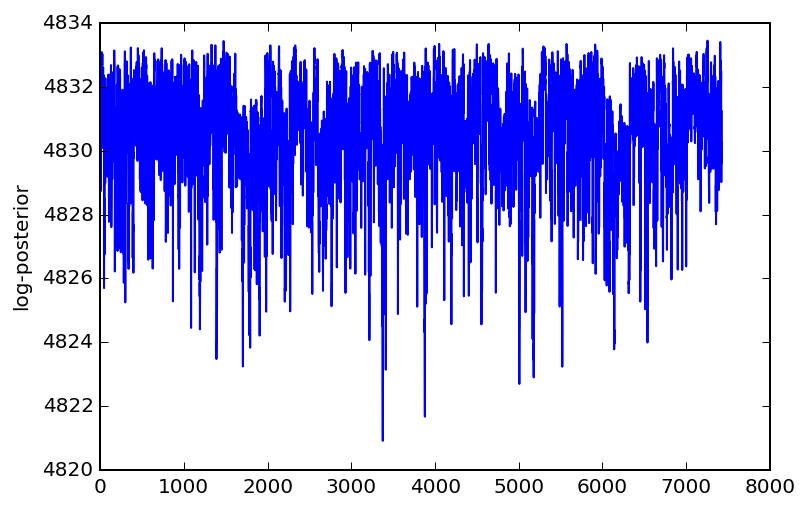

In [3]:
# plot posterior values to check for convergence
plt.plot(chain[burn:,-4])
plt.ylabel('log-posterior')

/Users/jaellis/miniconda2/envs/pal2_conda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


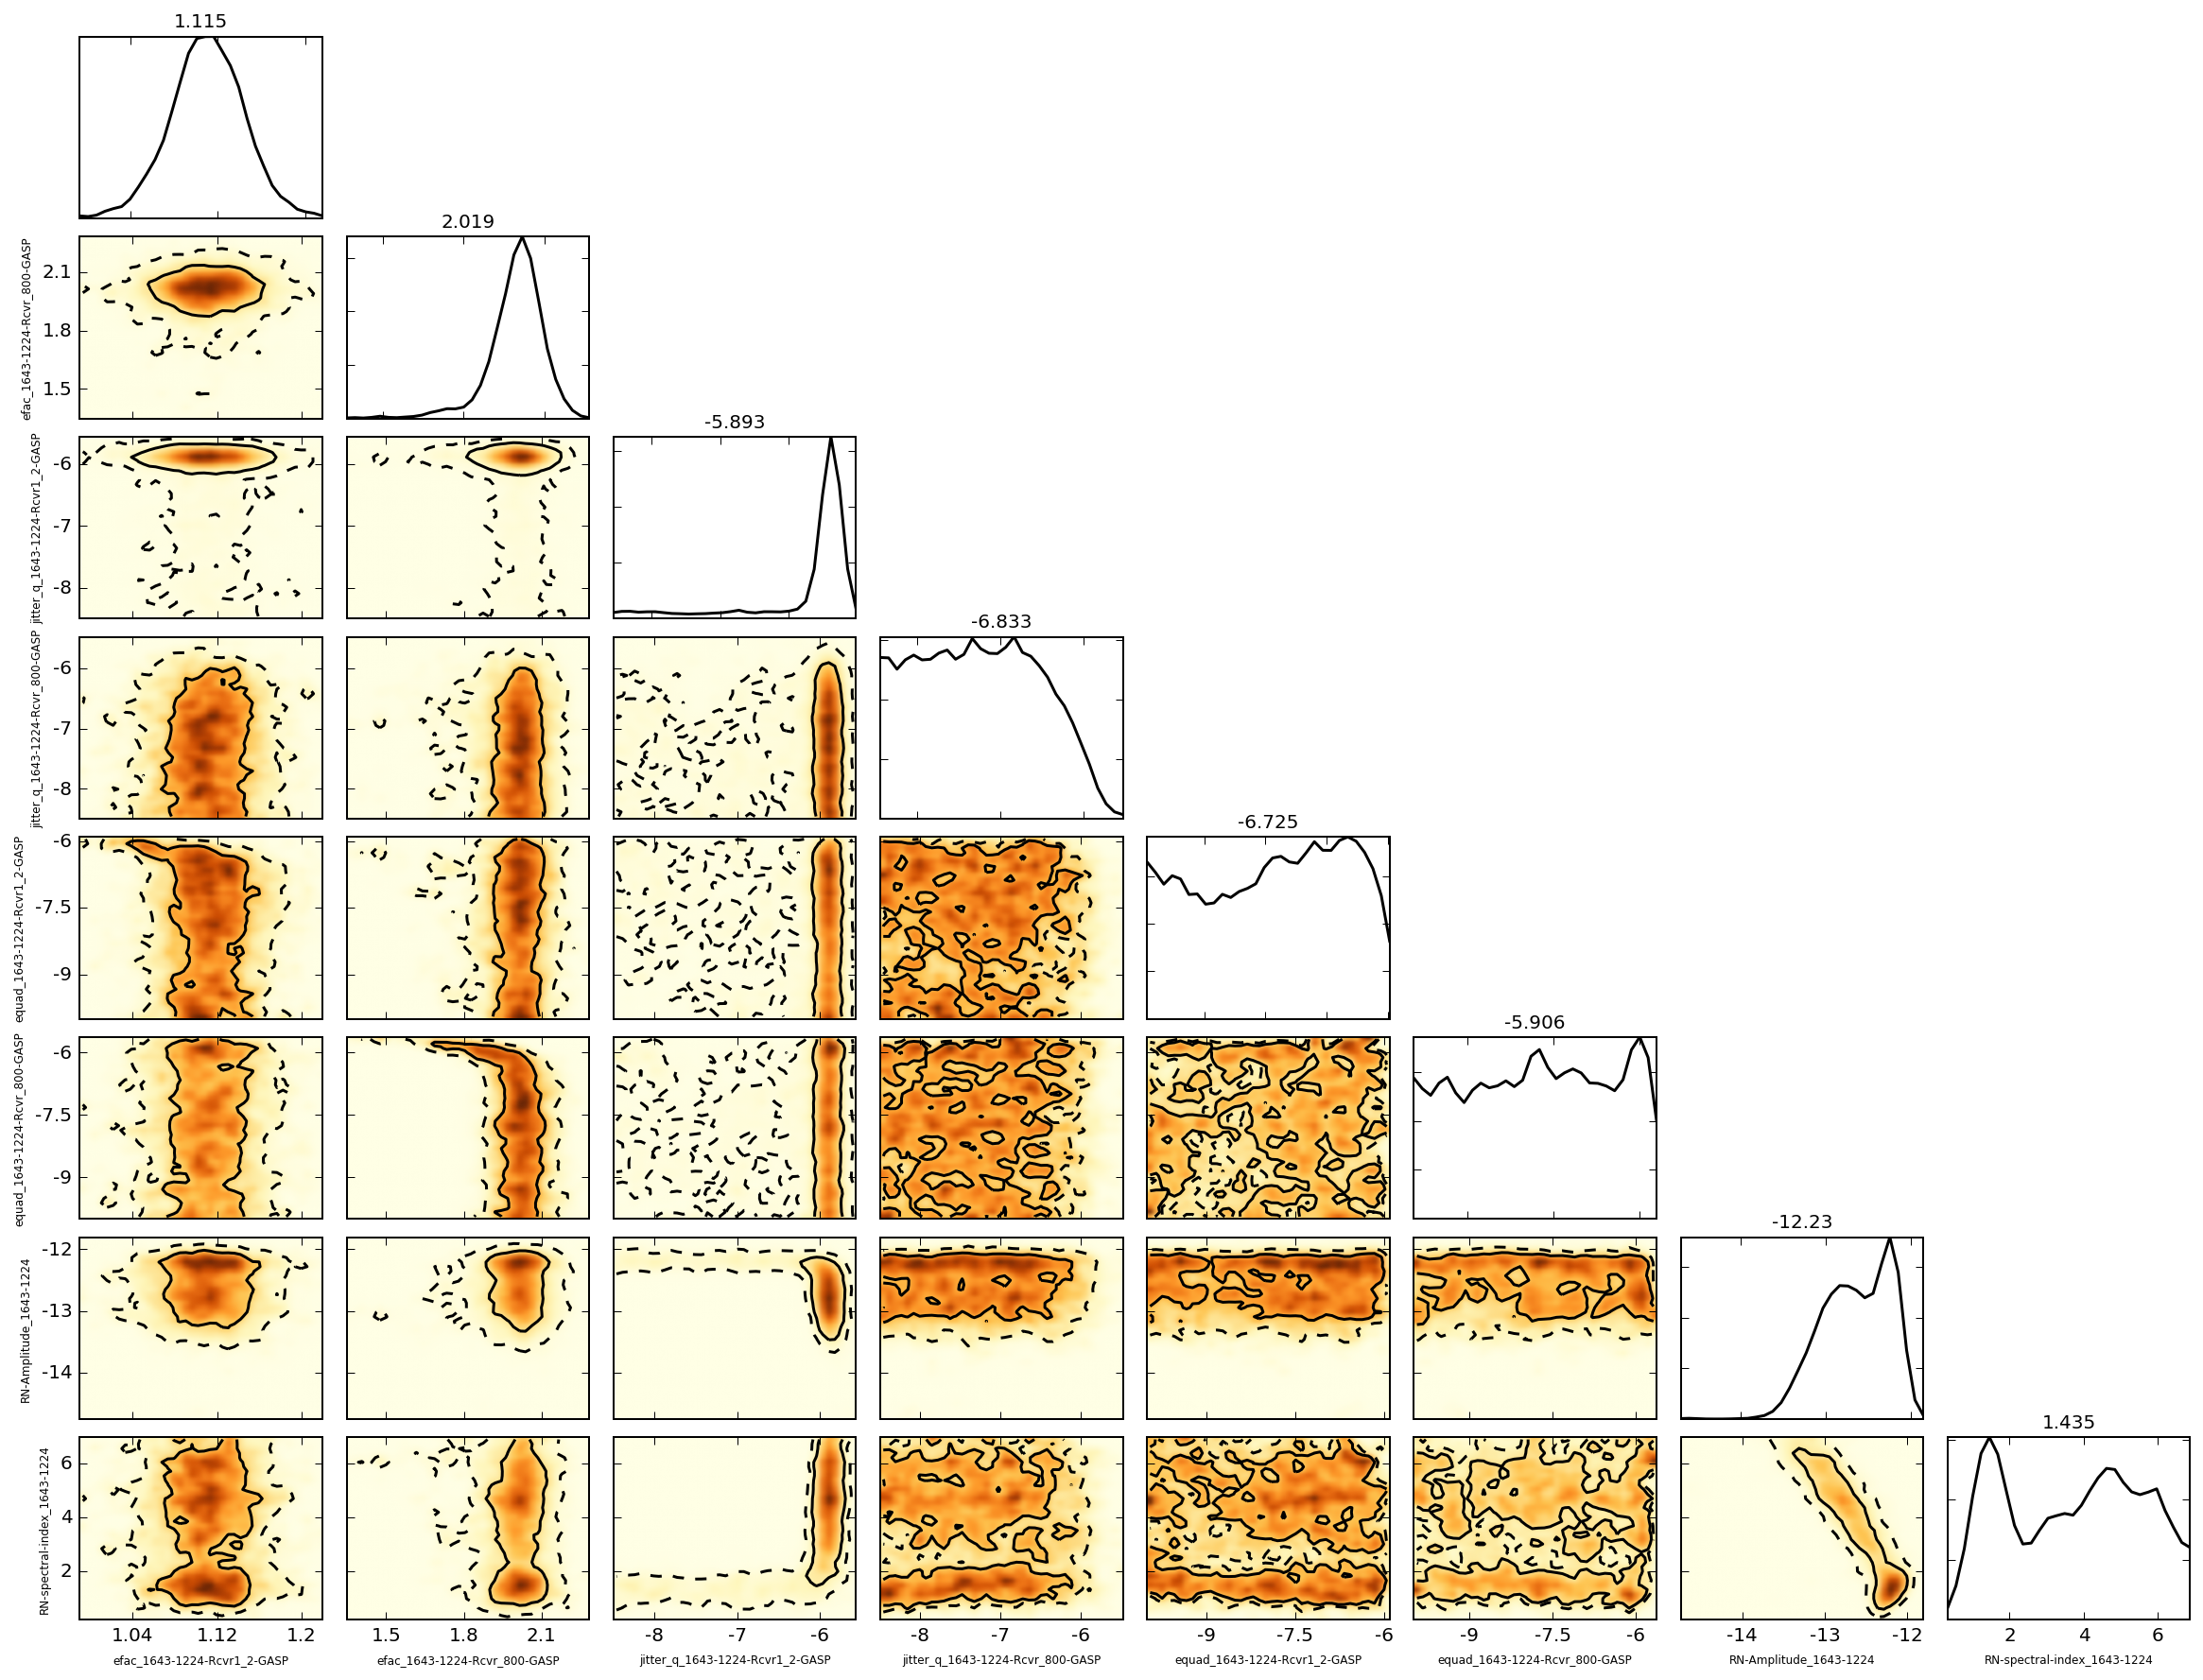

In [15]:
# plot triangle plot of values
plt.rcParams['font.size'] = 6
ax = bu.triplot(chain[burn:,:-4], labels=pars[:], tex=False, figsize=(20,15))

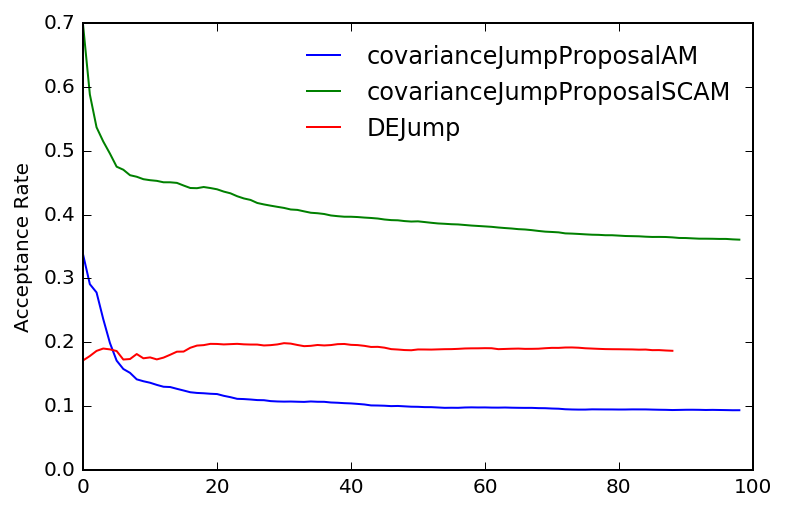

In [18]:
# plot acceptance rate for different jumps
plt.rcParams['font.size'] = 10
jumpfiles = glob.glob('chains/*jump.txt')
jumps = map(np.loadtxt, jumpfiles)
for ct, j in enumerate(jumps):
    plt.plot(j, label=jumpfiles[ct].split('/')[-1].split('_jump.txt')[0])
plt.legend(loc='best', frameon=False)
plt.ylabel('Acceptance Rate')

## makeH5file.py script

This script takes in the directory of your tim and par files and returns a single HDF5 file containing all of the timing information about each pulsar. This file will then be the entry point to all further analysis with PAL2.

In [2]:
!makeH5File.py -h

usage: makeH5File.py [-h] --pardir PARDIR --timdir TIMDIR --h5File H5FILE [--iter ITER]

Create HDF5 file for use in PAL2

optional arguments:
  -h, --help       show this help message and exit
  --pardir PARDIR  Full path to par files
  --timdir TIMDIR  Full path to tim files
  --h5File H5FILE  output hdf5 file
  --iter ITER      Number of iterations in fit [default=0]


## The PAL2_run.py script

This script is a more advanced verion of the commands that were used above. It tries to set the jump proposals and MCMC settings for the options that you want to run

In [ ]:
!PAL2_run.py -h

### Noise Estimation

The required arguments for PAL2_run are `--h5File` and `--pulsar`. The code will automatically use EFAC for all backends

The main flags to pay attention to here are

`--incRed`: This tells the sampler to include red noise

`--nf nf`: nf is the number of frequencies used to parameterize red noise

`--incEquad`: Use EQUAD per backend

`--incJitterEquad`: Use ECORR per backend

In [ ]:
!PAL2_run.py --h5File h5file.hdf5 --pulsar 1643-1224 --mark9 --incEquad --incRed \
--incJitterEquad --outDir chains/noise/1643-1224 --niter 10000

In [ ]:
chain = np.loadtxt('chains/noise/1643-1224/chain_1.txt')
burn = 0.25 * chain.shape[0]
pars = np.loadtxt('chains/noise/1643-1224/pars.txt', dtype='S42')

In [ ]:
plt.plot(chain[burn:,-4])

In [ ]:
ax = bu.triplot(chain[burn:,:-4], labels=list(pars[:]), tex=False, figsize=(20,15))

## Bayesian Timing

You should use the same noise model as before but now give it the relevant timing model options

`--incTimingModel`: This tells it to include the timing model

`--tmmodel nonlinear`: You can give this option linear or non-linear

For some cases, if you want to add or subtract parameters in the *same* binary model then you can use

`--addpars pars`: pars here are the tempo2 parameter names like SINI or M2

`--delpars pars`: same as above but for deleting parameters

In [ ]:
!PAL2_run.py --h5File h5file.hdf5 --pulsar 1643-1224 --mark9 --incEquad --incRed \
--incJitterEquad --incTimingModel --tmmodel nonlinear --outDir chains/timing/1643-1224 \
--niter 100000

In [ ]:
chain = np.loadtxt('chains/timing/1643-1224/chain_1.txt')
burn = 0.25 * chain.shape[0]
pars = np.loadtxt('chains/timing/1643-1224/pars.txt', dtype='S42')

In [ ]:
ax = bu.triplot(chain[burn:,8:-4], labels=list(pars[8:]), tex=False, figsize=(20,15))

## CW Upper limit

You can run with the same noise model as before but now include the following options

`--incCW`: Include continuous GW signal.

`--incPdist`: Include pulsar distance as search parameter.

`--cwModel`: Can be `standard` for normal search or `upperLimit` for search.

For this example though we are going to fix the noise parameters to pre-determined values so use the following arguments

`--fixNoise`: Option to fix noise

`--noisedir /path/to/directory`: Path to noise directory containing noise files

`--fixWhite`: This option only fixes white noise but allows red noise to vary. To fix all noise don't include this option.

Usually we will want to compute the upper limit for one frequency at a time so you can use

`--fixf freq`: freq is the value of the frequency (not the log!)

In [ ]:
!PAL2_run.py --h5File h5file.hdf5 --pulsar 1713+0747 1909-3744 1012+5307 1855+09 0030+0451 0613-0200 \
--mark9 --incEquad --incRed --incJitterEquad --incCW --incPdist --cwModel upperLimit --outDir chains/cw/all/ \
--fixNoise --noisedir noisefiles/ --fixWhite --niter 100000 --fixf 1e-8

## Stochastic Background upper limit

You can run with the same noise model as before but now include the following options

`--incGWB`: Include GWB signal

`--GWBAmpPrior prior`: Default is `log-uniform` but want `uniform` for upper limits. The `sesana` and `mcwilliams` prior uses gaussian priors on the amplitude based on Sesana (2013) or McWilliams (2014)

`--fixSi val`: Here value is the fixed power spectral index of GWB, by default it varies this parameter

`--noCorrelations`: Do not include cross correlations. THis is necessary to set if using ECORR for the moment.

`--Tspan val`: This sets the time span of the observations or the lowest frequency used in the PSD. By default this uses a separate value for each pulsar but for stochastic backgroun we either want to set the value explicitly or use `--Tspan 0` whic will automatically find the longest time span and set the frequencies accordingly.

When running an upper limit we also want to use a uniform prior on both the GWB and red noise amplitude

`--redAmpPrior prior`: prior is `log` by default but for upper limits we want `uniform`


For this example though we are going to fix the noise parameters to pre-determined values so use the following arguments

`--fixNoise`: Option to fix noise

`--noisedir /path/to/directory`: Path to noise directory containing noise files

`--fixWhite`: This option only fixes white noise but allows red noise to vary. To fix all noise don't include this option.

In [ ]:
!PAL2_run.py --h5File h5file.hdf5 --pulsar 1713+0747 1909-3744 1012+5307 1855+09 0030+0451 0613-0200 \
--mark9 --incEquad --incRed --incJitterEquad  --incGWB --fixSi 4.33 --GWBAmpPrior uniform --redAmpPrior uniform \
--outDir chains/stoch/all/ --fixNoise --noisedir noisefiles/ --fixWhite --niter 100000 --Tspan 0 --noCorrelations

In [ ]:
chain = np.loadtxt('chains/stoch/all/chain_1.txt')
burn = 0.25 * chain.shape[0]
pars = np.loadtxt('chains/stoch/all/pars.txt', dtype='S42')

### Upper limit on stochastic background

In [ ]:
xmin, xmax = bu.confinterval(chain[burn:,list(pars).index('GWB-Amplitude')], onesided=True, sigma=0.95)
a = plt.hist(chain[burn:,list(pars).index('GWB-Amplitude')], 50)
plt.axvline(xmax, color='r', lw=2)

print 10**xmax